# first we have to divide the data for our use case per day for each revenue center

In [10]:
import pandas as pd

file_path = "../data/raw/Hotel_Revenue_Data.xlsx"

# Use read_excel instead of read_csv
df = pd.read_excel(file_path, parse_dates=["Date"])

# Quick sanity-check
print(df.shape)
df.head()


(120562, 4)


,Date,MealPeriod,CheckTotal,RevenueCenterName
0,2023-04-18,Dinner,125.0,RevenueCenter_1
1,2023-04-18,Dinner,37.5,RevenueCenter_1
2,2023-04-18,Dinner,0.0,RevenueCenter_1
3,2023-04-18,Dinner,0.0,RevenueCenter_1
4,2023-04-18,Dinner,70.0,RevenueCenter_2


In [13]:
import pandas as pd
import itertools

# Step 1: Get all unique values
all_dates = df["Date"].unique()
all_meals = df["MealPeriod"].unique()
all_centers = df["RevenueCenterName"].unique()

# Step 2: Create full cartesian product of all combinations
all_combinations = pd.DataFrame(
    list(itertools.product(all_dates, all_meals, all_centers)),
    columns=["Date", "MealPeriod", "RevenueCenterName"]
)

# Step 3: Group actual data
actual_totals = (
    df.groupby(["Date", "MealPeriod", "RevenueCenterName"])["CheckTotal"]
    .sum()
    .reset_index()
    .rename(columns={"CheckTotal": "TotalCheckAmount"})
)

# Step 4: Merge with full combinations and fill missing with 0
final_df = (
    all_combinations
    .merge(actual_totals, on=["Date", "MealPeriod", "RevenueCenterName"], how="left")
    .fillna({"TotalCheckAmount": 0})
    .sort_values(by=["Date", "MealPeriod", "RevenueCenterName"])
)

# Step 5: Save to CSV
final_df.to_csv("complete_daily_revenue_totals.csv", index=False)

final_df.head()

,Date,MealPeriod,RevenueCenterName,TotalCheckAmount
963,2023-01-01,BreakFast,RevenueCenter_1,1499.4
964,2023-01-01,BreakFast,RevenueCenter_2,35.0
965,2023-01-01,BreakFast,RevenueCenter_3,0.0
966,2023-01-01,BreakFast,RevenueCenter_4,0.0
967,2023-01-01,BreakFast,RevenueCenter_5,21807.0


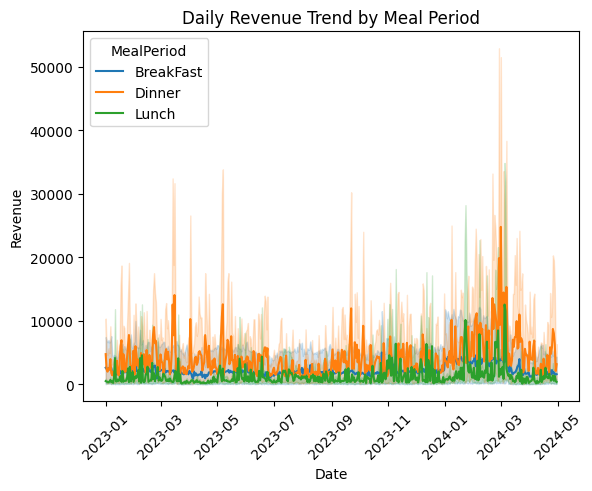

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a line plot with 'Date' on the x-axis and 'TotalCheckAmount' on the y-axis
# Different lines are colored by 'MealPeriod'
sns.lineplot(data=final_df, x="Date", y="TotalCheckAmount", hue="MealPeriod")

# Set the title of the plot
plt.title("Daily Revenue Trend by Meal Period")

# Label the y-axis as 'Revenue'
plt.ylabel("Revenue")

# Rotate x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


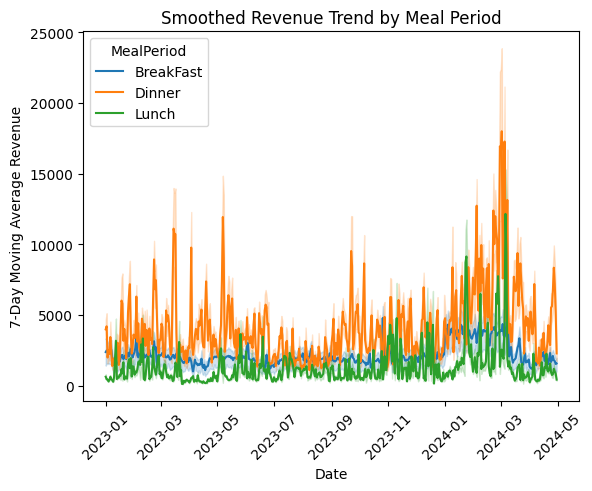

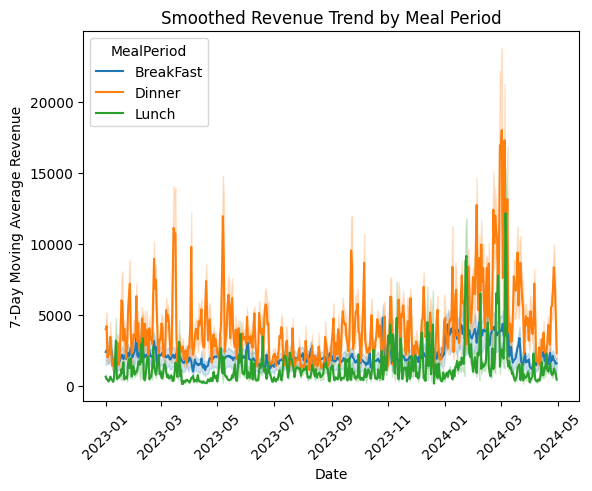

In [16]:
# Smooth revenue with 7-day moving average
smoothed = final_df.copy()
smoothed["TotalCheckAmount"] = smoothed.groupby("MealPeriod")["TotalCheckAmount"].transform(lambda x: x.rolling(7, min_periods=1).mean())

sns.lineplot(data=smoothed, x="Date", y="TotalCheckAmount", hue="MealPeriod")
plt.title("Smoothed Revenue Trend by Meal Period")
plt.ylabel("7-Day Moving Average Revenue")
plt.xticks(rotation=45)
plt.show()
# Smooth revenue with 7-day moving average
smoothed = final_df.copy()
smoothed["TotalCheckAmount"] = smoothed.groupby("MealPeriod")["TotalCheckAmount"].transform(lambda x: x.rolling(7, min_periods=1).mean())

sns.lineplot(data=smoothed, x="Date", y="TotalCheckAmount", hue="MealPeriod")
plt.title("Smoothed Revenue Trend by Meal Period")
plt.ylabel("7-Day Moving Average Revenue")
plt.xticks(rotation=45)
plt.show()


Text(0.5, 0.98, 'Revenue Trends by Revenue Center and Meal Period')

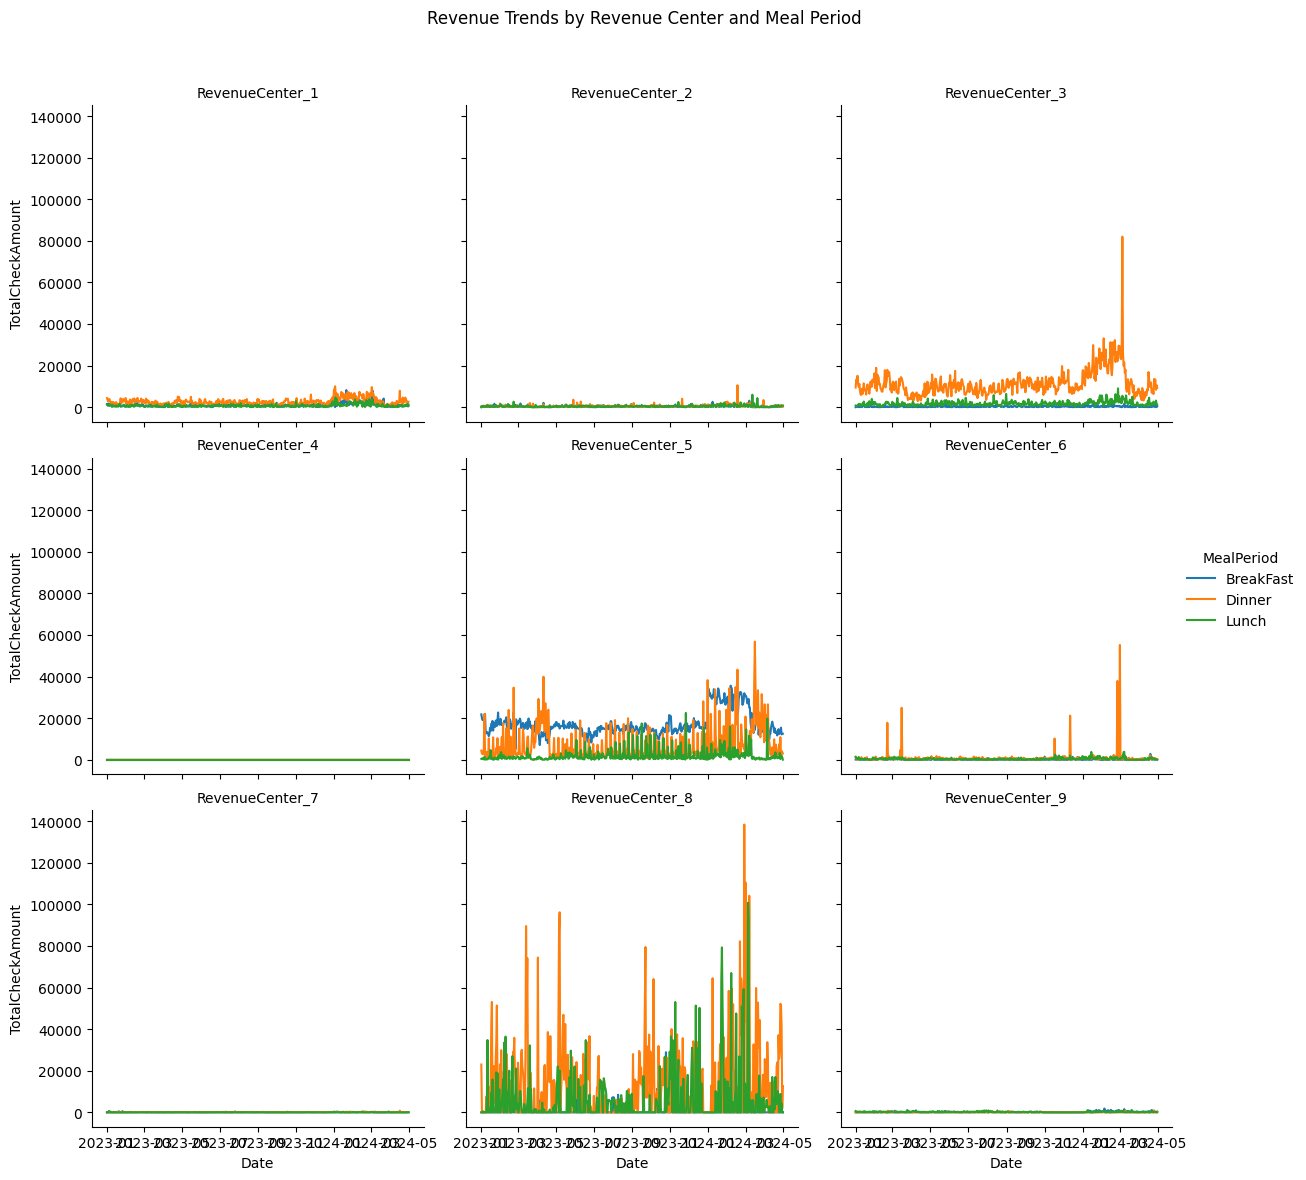

In [15]:
g = sns.FacetGrid(final_df, col="RevenueCenterName", hue="MealPeriod", col_wrap=3, height=4)
g.map(sns.lineplot, "Date", "TotalCheckAmount").add_legend()
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Revenue Trends by Revenue Center and Meal Period")


In [20]:
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Sort and apply 7-day moving average per MealPeriod + RevenueCenterName
smoothed_df = (
    final_df.sort_values("Date")
    .groupby(["MealPeriod", "RevenueCenterName"], as_index=False)
    .apply(lambda x: x.assign(SmoothedRevenue=x["TotalCheckAmount"].rolling(7, min_periods=1).mean()))
    .reset_index(drop=True)
)


C:\Users\pcsal\AppData\Local\Temp\ipykernel_26968\1164184104.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(SmoothedRevenue=x["TotalCheckAmount"].rolling(7, min_periods=1).mean()))


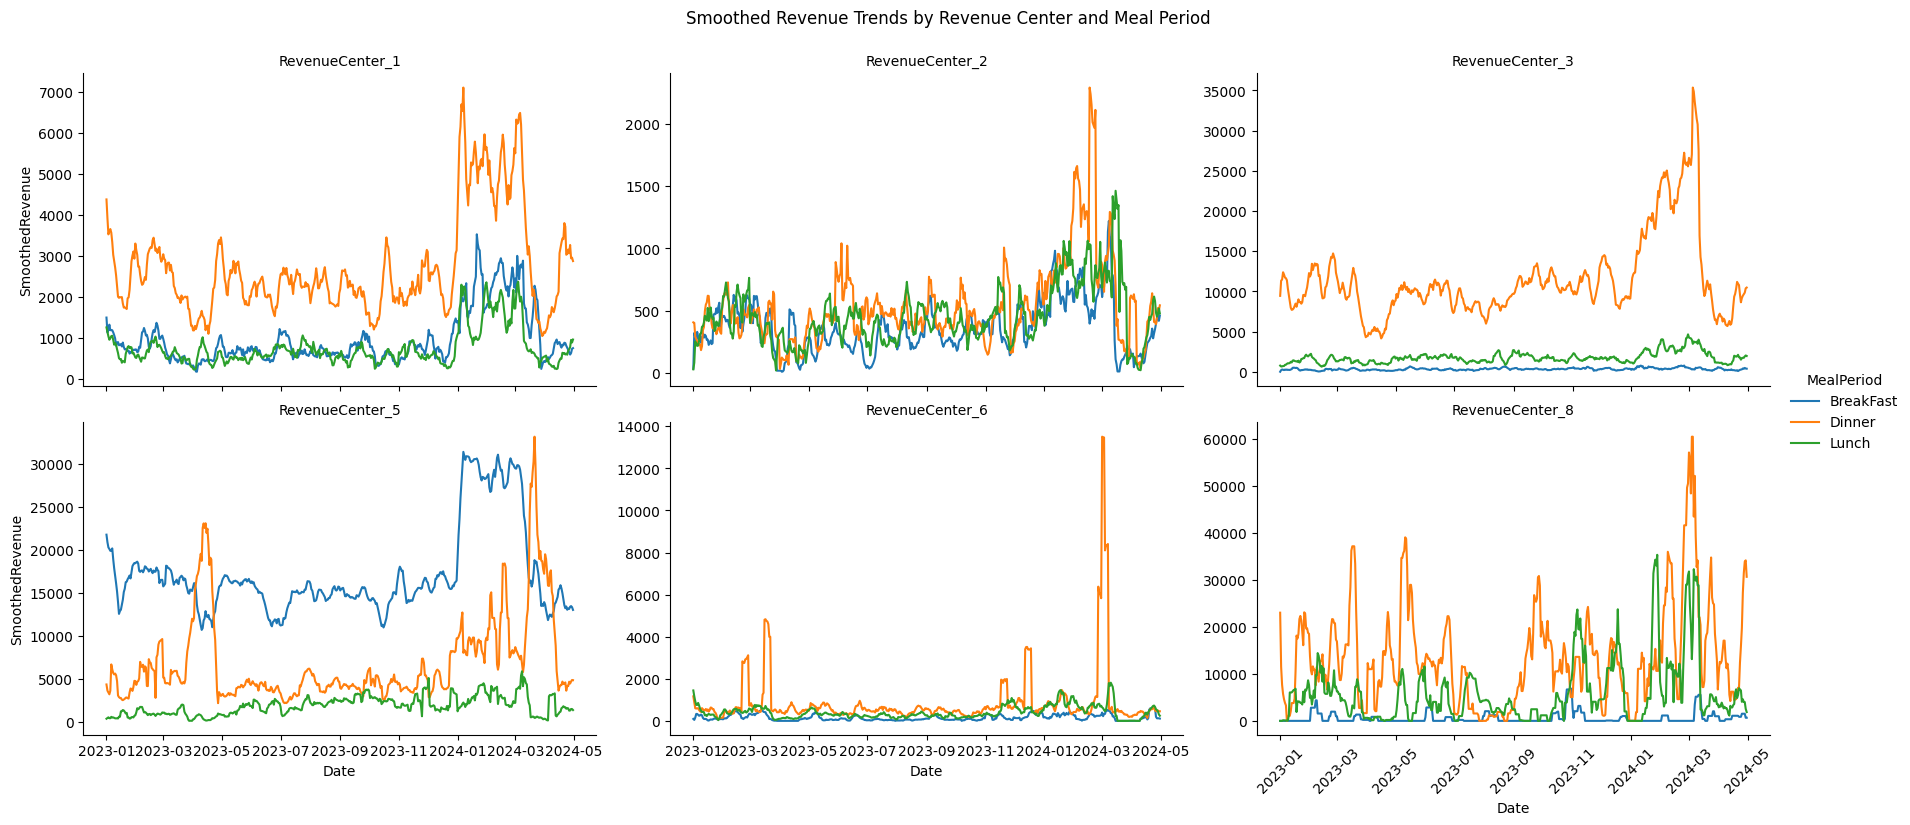

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot only active revenue centers (optional filter)
active_centers = smoothed_df.groupby("RevenueCenterName")["TotalCheckAmount"].sum().sort_values(ascending=False).head(6).index
filtered_df = smoothed_df[smoothed_df["RevenueCenterName"].isin(active_centers)]

g = sns.FacetGrid(
    filtered_df,
    col="RevenueCenterName",
    hue="MealPeriod",
    col_wrap=3,
    height=4,
    aspect=1.5,
    sharey=False
)

g.map(sns.lineplot, "Date", "SmoothedRevenue").add_legend()
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Smoothed Revenue Trends by Revenue Center and Meal Period")
plt.xticks(rotation=45)
plt.show()
